In [1]:
from joblib import Parallel, delayed
import multiprocessing

In [2]:
import os
import sys
import glob
import pickle
import itertools
import random
import copy

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm

from flowMP import *

np.random.seed(1234)
%matplotlib inline

In [3]:
def logP_Mondrian_Gaussian_perturbation(indiv_mp,template_mp,stepsize):
    """
    To-do: truncated Gaussian pdf
    """
    if template_mp[1] == None and template_mp[2] == None:
        return 0
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(template_mp[0].shape[0]):
        if template_mp[0][_,1] > template_mp[1][0][_,1]:
            break
    
    dim = _
    pos_template = template_mp[1][0][dim,1]
    pos_indiv = indiv_mp[1][0][dim, 1]
    
    res = norm(pos_template,(template_mp[0][dim,1] - template_mp[0][dim,0])*stepsize).logpdf(pos_indiv)
    
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[1],template_mp[1],stepsize)
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[2],template_mp[2],stepsize)
    return res


### function for computing joint probability
def joint_logP_Random_Effect(template_mp, indiv_mp_list, data_list, table, stepsize):
    """
    INPUT:
    template_mp: one mondrian process
    indiv_mp_list: a list of mondrian processes
    data_list: a list of cell*marker np array
    table: +1 -1 0 information
    """
    logP = comp_log_p_prior(template_mp, table, [1 for _ in range(table.shape[1])])
    n_sample = len(data_list)
    for _ in range(n_sample):
        logP += logP_Mondrian_Gaussian_perturbation(indiv_mp_list[_], template_mp, stepsize)
        logP += comp_log_p_sample(indiv_mp_list[_], data_list[_])
    return logP


## a mini MCMC run to initialize Mondrian process with data
def init_mp(theta_space, table, data, n_iter,mcmc_gaussin_std):
    # randomly draw a template mondrian process
    sample = draw_informed_Mondrian(theta_space, table)
    log_p_sample = comp_log_p_sample(sample, pooled_data) + \
                         comp_log_p_prior(sample, table, [1 for _ in range(table.shape[1])])

    for idx in xrange(n_iter):
        new_sample = Mondrian_Gaussian_perturbation(theta_space,sample, mcmc_gaussin_std)
        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data) + \
                            comp_log_p_prior(new_sample, table, [1 for _ in range(table.shape[1])])

        if new_log_p_sample >=  log_p_sample or \
            np.log(np.random.uniform(low=0, high=1.)) <= new_log_p_sample - log_p_sample:
            sample = new_sample
            log_p_sample = new_log_p_sample
    return sample

## Flow Cytometry Data

Load AML data from 21 samples, 5 of them are healthy (H\*), 16 of them are AML samples (SJ\*).

In [4]:
%%time

# load data into a dictionary of pandas data frames

PATH_DATA = '/extra/disij0/data/flow_cytometry/cytobank/levine_aml/CSV/'
#PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'

user_ids = ['H1','H2','H3','H4','H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
           'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']

data_dict = dict()
for id in user_ids:
    print id
    data_path = PATH_DATA + id
    allFiles = glob.glob(data_path + "/*fcsdim_42.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    data_dict[id] = pd.concat(list_)

H1
H2
H3
H4
H5
SJ01
SJ02
SJ03
SJ04
SJ05
SJ06
SJ07
SJ08
SJ09
SJ10
SJ11
SJ12
SJ13
SJ14
SJ15
SJ16
CPU times: user 1min 58s, sys: 4.82 s, total: 2min 3s
Wall time: 2min 3s


In [5]:
markers = ['HLA-DR','CD19','CD34','CD45','CD47','CD44','CD117','CD123','CD38','CD11b',\
                'CD7','CD15','CD3','CD64','CD33','CD41']
 
print markers
    
PATH_TABLE = '/home/disij/projects/acdc/data/AML_benchmark/'
table = pd.read_csv(PATH_TABLE + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
table = table[markers]
print table.shape
print table

cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
cell_type_idx2name = {i:x for i,x in enumerate(table.index)}

['HLA-DR', 'CD19', 'CD34', 'CD45', 'CD47', 'CD44', 'CD117', 'CD123', 'CD38', 'CD11b', 'CD7', 'CD15', 'CD3', 'CD64', 'CD33', 'CD41']
(14, 16)
                        HLA-DR  CD19  CD34  CD45  CD47  CD44  CD117  CD123  \
Basophils                 -1.0    -1    -1   0.0   0.0   0.0    0.0      1   
CD4 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD8 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16- NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16+ NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123- HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123+ HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0      1   
CD34+CD38lo HSCs           0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
Mature B cells             0.0     1    -1   0.0   0.0   0.0    0.0     -1   
Plasma B cells            -1.0     1    -1   0.0   0.0   0.0    0.0     -1   
P

Now run MCMC to collect posterior samples...

### Random effect model

In [6]:
def mcmc_template(chain):
   
    mcmc_gaussin_std = 0.1
    np.random.seed(1234+chain)
    
    accepts_template_mp_chain = []
    accepts_indiv_mp_lists_chain = [[] for i in range(n_samples)]
    joint_logP_chain = []
    
    ### INITIALIZE template_mp AND indivi_mp_list
    print "Initializing template mondrian process with pooled data"
    template_mp = init_mp(theta_space, table, pooled_data, 100, mcmc_gaussin_std)
    indiv_mp_list = [np.copy(template_mp) for _ in range(n_samples)] 
    accepts_template_mp_chain.append(template_mp)

    for idx in xrange(n_mcmc_sample):
        if idx == n_mcmc_sample / 3:
            mcmc_gaussin_std  = mcmc_gaussin_std / 5
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(template_mp, \
                    [indiv_mp_list[_]],[data[_]], table, random_effect_gaussian_std)
            new_log_p = joint_logP_Random_Effect(template_mp, \
                    [new_sample],[data[_]], table, random_effect_gaussian_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepts_indiv_mp_lists_chain[_].append(new_sample)
                
                
        # update template mondrian process
        new_sample = Mondrian_Gaussian_perturbation(
                    theta_space, template_mp, mcmc_gaussin_std)
        
        log_p = joint_logP_Random_Effect(template_mp, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)

        new_log_p = joint_logP_Random_Effect(new_sample, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepts_template_mp_chain.append(template_mp)
            
        joint_logP_chain.append(joint_logP_Random_Effect(template_mp, indiv_mp_list, \
                                data, table, random_effect_gaussian_std))

        if (idx + 1) % (n_mcmc_sample/4) == 0:
            print "Chain %d: Drawing Sample %d ..." % (chain, idx + 1)
            print "Accepted proposals of indiv mp, template mp: %d, %d, %d, %d, %d, %d" \
                    % (len(accepts_indiv_mp_lists_chain[0]), \
                       len(accepts_indiv_mp_lists_chain[1]), \
                       len(accepts_indiv_mp_lists_chain[2]), \
                       len(accepts_indiv_mp_lists_chain[3]), \
                       len(accepts_indiv_mp_lists_chain[4]), \
                       len(accepts_template_mp_chain))
                
    return accepts_template_mp_chain,accepts_indiv_mp_lists_chain,joint_logP_chain

#### Training models for healthy samples

In [7]:
f = lambda x: np.arcsinh((x -1.)/5.)
data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['H1','H2','H3','H4','H5']]

# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [8]:
%%time

n_mcmc_chain = 16
n_mcmc_sample = 2000
mcmc_gaussin_std = 0.1
random_effect_gaussian_std = 0.5

pooled_data = np.concatenate(data)

accepts_template_mp_H = []
accepts_indiv_mp_lists_H = []
joint_logP_H = []

chains = range(n_mcmc_chain)
num_cores = multiprocessing.cpu_count()
results_1 = Parallel(n_jobs=num_cores)(delayed(mcmc_template)(i) \
                                       for i in range(n_mcmc_chain/2))
results_2 = Parallel(n_jobs=num_cores)(delayed(mcmc_template)(i) \
                                       for i in range(n_mcmc_chain/2, n_mcmc_chain))
results = results_1 + results_2

for _ in results:
    accepts_template_mp_H.append(_[0])
    accepts_indiv_mp_lists_H.append(_[1])
    joint_logP_H.append(_[2])

Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Chain 2: Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 9, 5, 13, 9, 6, 91
Chain 1: Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 6, 5, 11, 5, 9, 123
Chain 6: Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 20, 18, 15, 18, 19, 115
Chain 5: Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 17, 8, 10, 9, 10, 85
Chain 3: Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 7, 10, 9, 14, 13, 105
Chain 0: Drawing Sample 500 ...
Accepted proposals of indiv m

In [9]:
accepts_template_mp_H = []
accepts_indiv_mp_lists_H = []
joint_logP_H = []

for _ in results:
    accepts_template_mp_H.append(_[0])
    accepts_indiv_mp_lists_H.append(_[1])
    joint_logP_H.append(_[2])

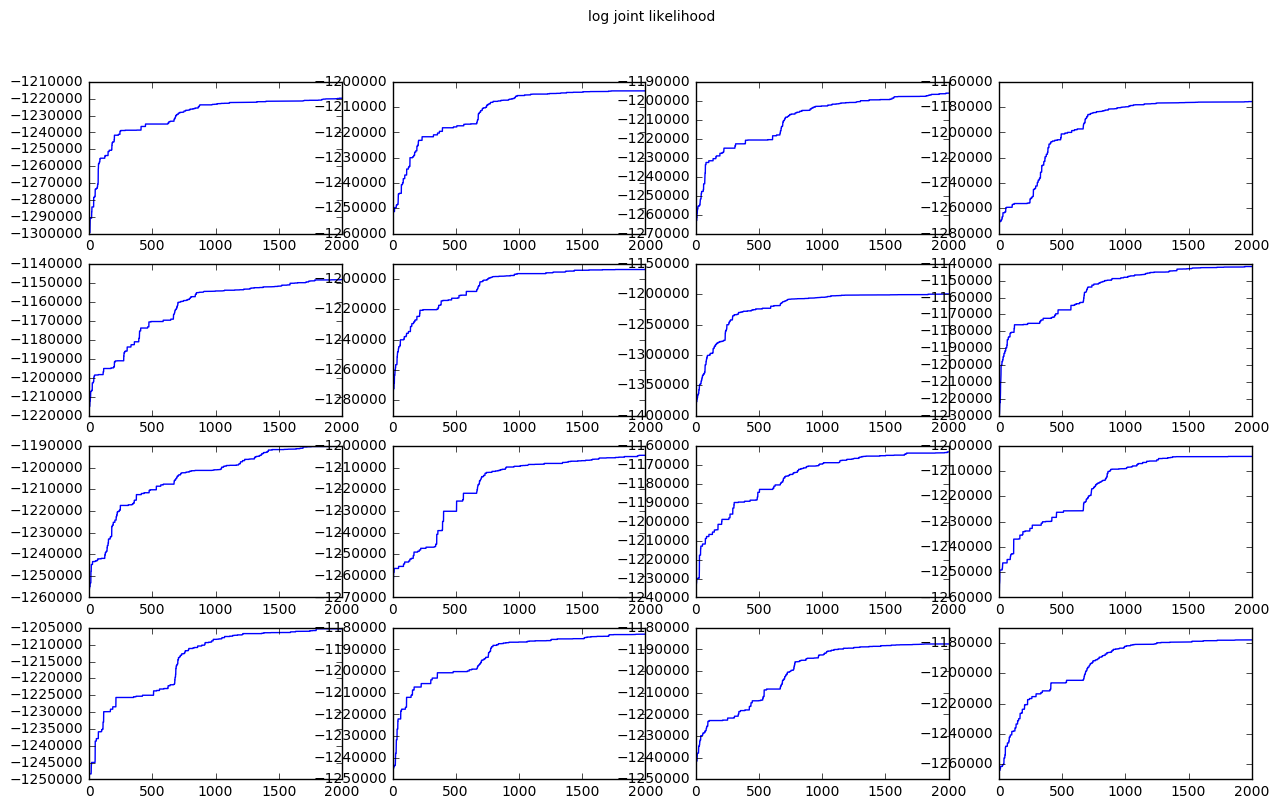

In [10]:
fig, axarr = plt.subplots(n_mcmc_chain / 4, 4, figsize=(15,6 * n_mcmc_chain / 10))
for i in range(n_mcmc_chain):
    axarr[i/4,i%4].plot(joint_logP_H[i])
fig.suptitle("log joint likelihood")
plt.show()

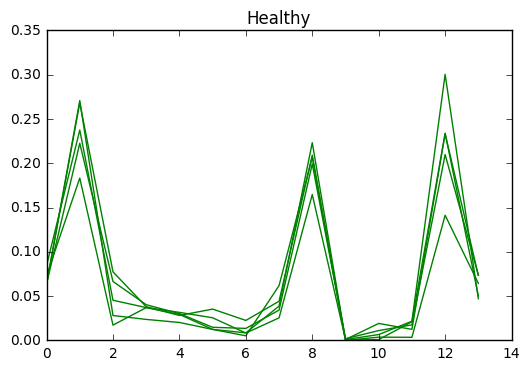

In [11]:
population_size_H = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_H[_][id][-2:]]
    burnt_predictions = [None for i in burnt_samples]
    for i in range(len(burnt_samples)):
        burnt_predictions[i] = classify_cells(data_subset, burnt_samples[i], \
                                              table, cell_type_name2idx)
    votes = np.zeros([data_subset.shape[0], table.shape[0]])
    for Y_predict in burnt_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)

    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    population_size_H[id] = [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]

for id in range(n_samples):
    plt.plot(population_size_H[id],color = 'g')
plt.title('Healthy')
plt.show()

In [12]:
for i in range(5):
    print accepts_template_mp_H[i][-1]

(array([[-0.38533609,  7.52040389],
       [-0.3952843 ,  5.25160317],
       [-0.39450834,  6.07257102],
       [-0.34880582,  7.88441537],
       [-0.37291764,  7.36852688],
       [-0.36262864,  8.11851074],
       [-0.39615364,  5.31116836],
       [-0.39616764,  6.12203258],
       [-0.38998018,  7.9539723 ],
       [-0.39430939,  5.41311391],
       [-0.39558451,  6.99983781],
       [-0.38956657,  6.89324954],
       [-0.39106164,  7.05299961],
       [-0.38520152,  6.28168149],
       [-0.39011893,  6.35074687],
       [-0.39410804,  8.50836366]]), (array([[-0.38533609,  7.52040389],
       [-0.3952843 ,  5.25160317],
       [-0.39450834,  6.07257102],
       [-0.34880582,  7.88441537],
       [-0.37291764,  7.36852688],
       [-0.36262864,  8.11851074],
       [-0.39615364,  5.31116836],
       [-0.39616764,  1.10887206],
       [-0.38998018,  7.9539723 ],
       [-0.39430939,  5.41311391],
       [-0.39558451,  6.99983781],
       [-0.38956657,  6.89324954],
       [-0.39106

#### Training models for unhealthy samples

In [ ]:
data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['SJ01','SJ02',\
            'SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
            'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']]
 
# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [ ]:
%%time

n_mcmc_chain = 16
n_mcmc_sample = 2000
mcmc_gaussin_std = 0.1
random_effect_gaussian_std = 0.5

pooled_data = np.concatenate(data)

accepts_template_mp_SJ = []
accepts_indiv_mp_lists_SJ = []
joint_logP_SJ = []

results_1 = Parallel(n_jobs=num_cores)(delayed(mcmc_template)(i) \
                                       for i in range(n_mcmc_chain/2))
results_2 = Parallel(n_jobs=num_cores)(delayed(mcmc_template)(i) \
                                       for i in range(n_mcmc_chain/2, n_mcmc_chain))
results = results_1 + results_2

for _ in results:
    accepts_template_mp_SJ.append(_[0])
    accepts_indiv_mp_lists_SJ.append(_[1])
    joint_logP_SJ.append(_[2])

Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data


In [ ]:
fig, axarr = plt.subplots(n_mcmc_chain / 4, 4, figsize=(15,6 * n_mcmc_chain / 10))
for i in range(n_mcmc_chain):
    axarr[i/4,i%4].plot(joint_logP_SJ[i])
fig.suptitle("log joint likelihood")
plt.show()

In [ ]:
population_size_SJ = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_SJ[_][id][-1:]]
    burnt_predictions = [None for i in burnt_samples]
    for i in range(len(burnt_samples)):
        burnt_predictions[i] = classify_cells(data_subset, burnt_samples[i], \
                                              table, cell_type_name2idx)
    votes = np.zeros([data_subset.shape[0], table.shape[0]])
    for Y_predict in burnt_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)

    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    population_size_SJ[id] = [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]

for id in range(n_samples):
    plt.plot(population_size_SJ[id],color = 'r')
plt.title('AML')
plt.show()

In [ ]:
for i in range(16):
    print accepts_template_mp_SJ[i][-1]

#### compare size of subpopulations in healthy and AML individuals

In [ ]:
fig, axarr = plt.subplots(2, 1,sharey=True)
for id in range(0,5):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('healty')
for id in range(0,16):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('AML')
plt.show()

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn import linear_model

loo = LeaveOneOut()
X = np.array(population_size_H  + population_size_SJ)
Y = np.array([0]*5  + [1]*16)
models = []

predict_prob = []
for train, test in loo.split(X,Y):
    train_X = X[train]
    train_Y = Y[train]
    test_X = X[test]
    test_Y = Y[test]
    logreg = linear_model.LogisticRegression(C=1e5)
    logreg.fit(train_X, train_Y)
    test_Y_predict = logreg.predict(test_X)
    models.append(logreg)
    predict_prob.append(logreg.predict_proba(test_X)[0][0])

In [ ]:
plt.scatter(range(21),predict_prob,s = 100)
plt.xlim(0, 21)
plt.ylim(0, 1)
plt.xlabel('Patient ID')
plt.ylabel('P(healthy)')
plt.title('P(healthy) Predicted by LOOCV Logistic Regression')

In [ ]:
cell_types = [cell_type_idx2name[i] for i in range(14)]

fig, axarr = plt.subplots(2, 1,sharey=True, sharex = True)
for id in range(5):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('Proportion of each cell type for Healty individuals')
for id in range(16):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('Proportion of each cell type for AML individuals')

plt.xticks(range(14),cell_types,rotation = 90)
plt.show()

for i in range(21):
    plt.plot(models[i].coef_[0])
plt.title('LOOCV Logistic Regression Coefficients')
plt.xticks(range(14),cell_types,rotation = 90)
plt.show()